# Start to Finish Example: BBH Merger From $\psi_4$ Data to MP4 Movie

## Author: Tyndale Stutzman, Seth Winchell

## This tutorial provides an overview of how to take primitive binary black hole merger data ($\psi_4$) and visualize it as an MP4 movie.

## Introduction: 

Among a plethora of data produced by the Black Holes At Home (BH@H) project, $\psi_4$ data is the most valuable for visualization purposes as it contains information regarding gravitational wave strain, $\textit{h}$. The purpose of this notebook is to provide a general example of extracting $\textit{h}$ from $\psi_4$, creating a series of meshes, and finally animating these meshes along with their constituent black holes in a final, downloadable movie that can then be edited in post. As such, this tutorial is not in depth, however, links to more detailed notebooks can be found in certain sections. 

<!-- note to anyone reading this... do we need more of a casual introduction here? How much do we talk about it vs diving in? Thanks. -->

### Prerequisites:

Before continuing in this tutorial, if you do not already have VisIt installed on your local system, refer to [**Tutorial_BlackHolesAtHome_PythonToVisIt**](Tutorial_BlackHolesAtHome_PythonToVisIt.ipynb) for a guide to setting up VisIt and interfacing via Python. 

### Recommended:

While the following references are not critical to producing a movie given BH@H data, they provide valuable insight into the underlying concepts behind each step in this overview. <!-- redundant? -->

<!-- stupid question but I'm assuming I can't use visit all packaged up in the notebook, right? -->

###### *This notebook is very much in progress

<a id='toc'></a>
# Table of Contents:
$$\label{toc}$$
<!--these buttons aren't functioning properly so maybe figure that out-->
1. [Step 1](#psi4_to_h): Extracting $\textit{h}$ from $\psi_4$
    1. [1.a](#freq_int): Domain expansion: frequency integration <!-- Yes I'll change the name to something more serious-->
    1. [1.b](#filter): Noise filtering
1. [Step 2](#mesh_gen): Generate gravitational wave mesh
1. [Step 3](#sync): Synchronize mesh with black hole trajectories
1. [Step 4](#animate): Animate gravitational wave meshes
    1. [4.1](#render): Render meshes and black holes
    1. [4.2](#pan): Pan Camera <!-- maybe this shouldn't be a feature of the example? -->
    1. [4.3](#ffmpeg): Compile frames with FFMPEG
1. [Step 5](#conclusion): Conclusion
1. [Step 6](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='psi4_to_h'></a>

# Step 1: Extracting $\textit{h}$ from $\psi_4$ \[Back to [top](#toc)\]
$$\label{psi4_to_h}$$

In order to process $\psi_4$ into a form that can be visualized, the gravitational wave strain $\textit{h}$ must first be extracted. $\psi_4$ is one of the five [Weyl Scalars](https://en.wikipedia.org/wiki/Weyl_scalar) that describe the curvature of spacetime affected by gravitational waves, and best corresponds to the transverse wave radiation strain, $\textit{h}$. Strain is comprised of a "plus" and "cross" polarization, where each component stretches spacetime at a 45 degree difference - this is expressed as a complex value, and in the simplest sense can be found through a **double time integration** of $\psi_4$ data. A full gravitational waveform is also a superposition of different $(\textit{l}, \textit{m})$ wave modes, similar in concept to a quantum mechanical wave equation, so a gravitational wave strain can be expressed through its components as:

$$\textit{h} = \sum_{l=2}^8 \sum_{m=-l}^l \textit{h}_{+}^{lm} - \textit{ih}_{\times}^{lm}$$

Unfortunately a direct double integration in the time domain of $\psi_4$ is insufficient in visualizing strain, mainly for two reasons:

* **Non-linear drifts in data:** Without alternative methods a 2D graph of the strain against time looks to drift upward as the binary system approaches merger and beyond.

* **Unphysical noise in the wave:** Because current data collection methods for $\psi_4$ are imperfect, they often pick up spurious signals unrelated to the system that are still present in a double time domain integration.

To alleviate these issues the data for visualization is instead [**integrated in the frequency domain**](#freq_int) by performing a Fast Fourier Transform (FFT) on the $\psi_4$ data before going through a simple Fixed Frequency Integration (FFI) formula - an inverse FFT is then done on the result to retrieve $h$. The FFI formula only depends on the associated frequency where we integrate the wave, so [**noise filtering**](#filter) is applied during FFI by calculating and applying a minimum cutoff frequency to exclude unphysical noise in the data. At the same time this technique will get rid of the upward drift mentioned before - two birds with one stone!

Recall that a full gravitational wave strain needs to account for all the $(\textit{l}, \textit{m})$ modes, specifially from $l = 2$ to $l = 8$. This **integration is repeated for all the modes** and reconstructed with [**spin-weighted spherical harmonics (link to section here)**]() later before visualizing.

###### For a more technical summary of these waveform integration techniques, please see [**this paper by Reisswig and Pollney**](https://arxiv.org/abs/1006.1632)


<a id='freq_int'></a>

## Step 1.a: Domain expansion: frequency integration \[Back to [top](#toc)\]
$$\label{freq_int}$$

Fortunately the `numpy` module has functions that can take a **Fast Fourier Transform (FFT)** and its associated frequencies with ease:

In [ ]:
import numpy as np

# Take the FFT using a list of the complex values of psi4 from our original data
fft_result = np.fft.fft(real_psi4 + 1j * imag_psi4) 

# Find the sample frequencies corresponding to each data point going into the FFT
omega_list = np.fft.fftfreq(len(psi4_times), dt) * 2 * np.pi

But where's the fun in that if we don't know what a Fourier transform is and how it can help with simplifying integration?

A **Fourier transform** will turn a regular time dependent function, say $g(t)$, and express it as a function of frequencies present in $g(t)$. A Fourier transform of a simple waveform can be thought of as first breaking a wave into its constituent pure waves, then taking those and casting it into the **frequency domain**, where they appear as peaks at their corresponding frequencies. A Fourier transform of a wave composing of 3 sine waves then looks like:

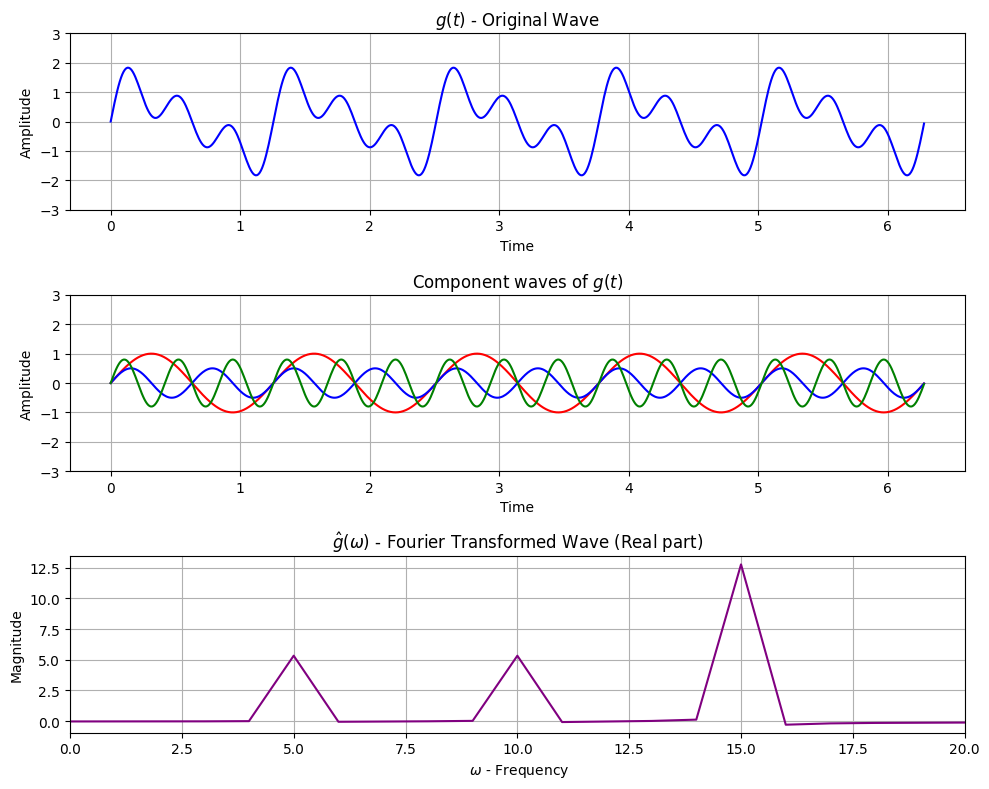

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the sine waves
amplitude1 = 1.0
frequency1 = 5.0
amplitude2 = 0.5
frequency2 = 10.0
amplitude3 = 0.8
frequency3 = 15.0

# Generate x values from 0 to 2*pi with a step size of 0.01
x = np.arange(0, 2*np.pi, 0.01)

# Create three sine waves
wave1 = amplitude1 * np.sin(frequency1 * x)
wave2 = amplitude2 * np.sin(frequency2 * x)
wave3 = amplitude3 * np.sin(frequency3 * x)

# Combine the three waves to form the composite wave
composite_wave = wave1 + wave2 + wave3

# Compute the Fourier transform of the composite wave
fourier_transform = np.fft.fft(composite_wave)

# Plot the original wave
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(x, composite_wave, color='blue')
plt.title(r'$g(t)$ - Original Wave')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-3, 3)

# Plot the 3 decomposed sine waves
plt.subplot(3, 1, 2)
plt.plot(x, wave1, color="red")
plt.plot(x, wave2, color="blue")
plt.plot(x, wave3, color="green")
plt.title(r'Component waves of $g(t)$')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.ylim(-3, 3)

# Plot the Fourier transformed wave
plt.subplot(3, 1, 3)
plt.plot(fourier_transform.real, color='purple')
plt.title(r'$\^g(\omega)$ - Fourier Transformed Wave (Real part)')
plt.xlabel(r' $\omega$ - Frequency')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 20)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

Matching the $\omega$ with each peak shows that the Fourier transform "picked out" the frequencies that made up the original wave! But you may have noticed that what was plotted was only the "real" part of the Fourier transform, which suggests that  this operation spits out a complex value. That observation is indeed true, and can be verified by the **mathematical expression of the Fourier transform**:

$$\^g(\omega) = \int_{-\infty}^{\infty} g(t)e^{-2i\pi\omega t} \, dt$$

(Continue here, explain math, introduce FFI)

<a id='filter'></a>

## Step 1.b: Noise filtering\[Back to [top](#toc)\]
$$\label{filter}$$

(Details on finding min_omega_ell2_m2 - fitting quadratic, dominant mode for all, etc.)

<a id='fft'></a>

# Step 2: Generate gravitational wave mesh \[Back to [top](#toc)\]
$$\label{mesh_gen}$$

Now that the gravitational wave strain has been extracted, it can be used in conjunction with [Spin Weighted Spherical Harmonics](https://demonstrations.wolfram.com/SpinWeightedSphericalHarmonics/) to calculate and create a manifold-like mesh for each time state. This step is achieved using the VTK python library to generate an unstructured mesh of points which can be visualized as a 2D surface in VisIt. 

<!-- more or less info? Either way, dive in... -->

<a id='sync'></a>

# Step 3: Synchronize mesh states with black hole trajectories \[Back to [top](#toc)\]
$$\label{sync}$$

Before directly reading gravitational wave meshes into VisIt, the mesh time steps must first be synchronized with the time steps of the constituent black hole trajectories <!-- too wordy? -->. 

(Joey will have to explain more to me about his methods before I can work on this section.)

<a id='animate'></a>

# Step 4: Animate gravitational wave meshes and black holes \[Back to [top](#toc)\]
$$\label{animate}$$

Finally, with all the necessary data processed, VisIt can be used through python to render each step time step. Once each frame is saved to a folder, FFMPEG is used to generate an MP4. As a preliminary note, VisIt can be picky with attribute parameters, in which case this notebook might provide some insight <!-- link to section of util/troubleshooting script on VisIt problems -->.


<a id='render'></a>

## Step 4.a: Render meshes and black holes\[Back to [top](#toc)\]
$$\label{render}$$ <!-- it just occured to me that the black holes will also be meshes ergo is this too ambiguous?-->
(Initial loadin. For this I'd like to only load in from a specific time step. Ideally at this point we've only generated a few meshes for the waves around merger time just for the sake of concision)

<a id='pan'></a>

## Step 4.b: Pan camera \[Back to [top](#toc)\]
$$\label{pan}$$

(as I mentioned in the comment on TOC, this step might be better omitted)

<a id='ffmpeg'></a>

## Step 4.c:  Compile frames with FFMPEG \[Back to [top](#toc)\]
$$\label{ffmpeg}$$

Lastly, with the following simple command, each frame generated by VisIt is compiled into a tidy MP4 video. 

<a id='conclusion'></a>

# Step 5: Conclusion \[Back to [top](#toc)\]
$$\label{conclusion}$$

(overview of what we did)

#### Reference and continued reading:
(through some sources and neat stuff here)

<a id='latex_pdf_output'></a>

# Step 6: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Psi4_to_mp4.pdf](Tutorial-Start_to_Finish-Psi4_to_mp4.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

(quick note, we might not even need this, figured I'd put it in here for now. It will require the necessary tools from nrpy)

In [ ]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-Psi4_to_mp4")

ModuleNotFoundError: No module named 'cmdline_helper'